In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [53]:
#!pip install imblearn

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#### 1. Read the data

In [10]:
# 0 - Malignant, 1 - Benign
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
X = df.drop('target', axis=1)
y = df['target']

#### 2. Examine the data

In [13]:
df.shape

(569, 31)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

##### Check Class distribution

In [20]:
class_counts = df['target'].value_counts()
class_counts

target
1    357
0    212
Name: count, dtype: int64

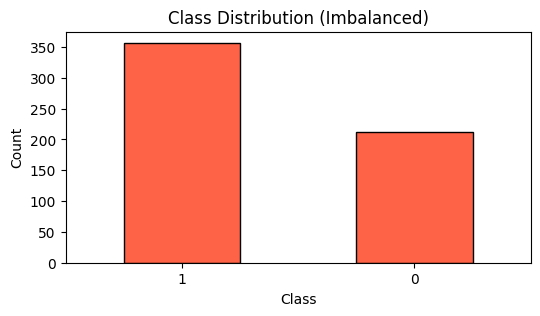

In [26]:
plt.figure(figsize=(6,3))
class_counts.plot(kind='bar', color='tomato', edgecolor='k')
plt.title('Class Distribution (Imbalanced)')
plt.xticks(rotation=0)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

>Note: Data is slightly imbalanced

##### Check for missing values

In [16]:
df.isnull().sum().sum()

0

>Note: No missing values are detected

In [18]:
#df.isnull().sum()

##### Check for duplicates

In [19]:
df.duplicated().sum()

0

>Note: No duplicate data

#### Check for outliers in the data

In [28]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [36]:
def detect_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] < lower) | (dataframe[column] > upper)]

In [43]:
outliers_example = detect_outliers_iqr(df, 'mean radius')
#outliers_example
print("Outliers in mean radius:", outliers_example.shape[0])

Outliers in mean radius: 14


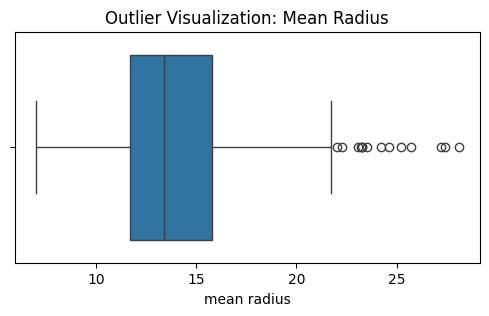

In [44]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['mean radius'])
plt.title('Outlier Visualization: Mean Radius')
plt.show()

In [45]:
def clip_outliers_iqr(data, cols):
    '''
    Method to replace null values
    '''
    data = data.copy()
    
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        data[col] = data[col].clip(lower, upper)
        
    return df

In [46]:
help(clip_outliers_iqr)

Help on function clip_outliers_iqr in module __main__:

clip_outliers_iqr(data, cols)
    Method to replace null values



In [ ]:
clip_outliers_iqr()

#### Split Data into train and test

In [52]:
from sklearn.model_selection import train_test_split, SMOTE

ImportError: cannot import name 'SMOTE' from 'sklearn.model_selection' (/opt/anaconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/model_selection/__init__.py)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [50]:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64
target
1    0.626374
0    0.373626
Name: proportion, dtype: float64
target
1    0.631579
0    0.368421
Name: proportion, dtype: float64


In [51]:
# ------------------------------------------------------------
# 8. Handling Imbalanced Data (SMOTE)
# ------------------------------------------------------------
# SMOTE only on training data
#	•	Synthetic → Creates new, artificial data points
#	•	Minority → For the under-represented class
#	•	Over-sampling → Increases the number of minority samples
#	•	Technique → A systematic algorithm (not random duplication)

In [56]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [57]:
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("\nClass distribution after SMOTE:\n", y_train_smote.value_counts())

Class distribution before SMOTE:
 target
1    285
0    170
Name: count, dtype: int64

Class distribution after SMOTE:
 target
1    285
0    285
Name: count, dtype: int64


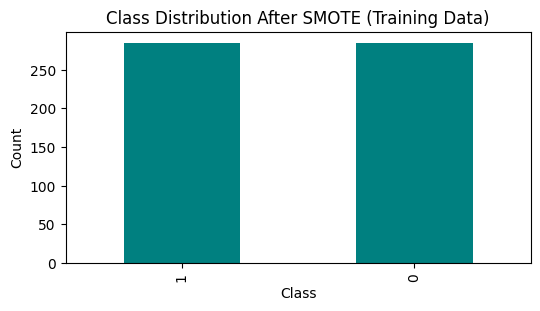

In [60]:
# Visualize class balance after SMOTE
plt.figure(figsize=(6,3))
y_train_smote.value_counts().plot(kind='bar', color='teal')
plt.title('Class Distribution After SMOTE (Training Data)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

##### Create a pipeline

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [66]:
log_reg = LogisticRegression(
    max_iter=1000
)

In [68]:
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', log_reg)
])

In [69]:
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10]
}

In [71]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

/opt/anaconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/ai_env/lib/python3.9/site-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(

Best parameters: {'model__C': 1, 'model__penalty': 'l2'}
Best CV ROC-AUC: 0.9958720330237357


In [72]:
best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\nTrain Classification Report")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report")
print(classification_report(y_test, y_test_pred))


Train Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       170
           1       0.99      1.00      0.99       285

    accuracy                           0.99       455
   macro avg       0.99      0.99      0.99       455
weighted avg       0.99      0.99      0.99       455


Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        42
           1       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

